In [2]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
log = pd.read_csv('Log_Problem.csv')

In [4]:
features = ['is_correct', 'is_hint_used', 'total_sec_taken', 'total_attempt_cnt']

# Example features
def aggregate_log(data, by, features):
    mean_features = data[[by]+features].groupby([by]).mean().reset_index()
    return mean_features
  
user_log = aggregate_log(log, 'uuid', features)

Finished 'clustering_preprocessing' in 0.822 secs
Beginning iteration for KMeans
Finished 'run_clustering' in 769.952 secs
Finished iteration for KMeans

Beginning iteration for GaussianMixture
Finished 'run_clustering' in 440.793 secs
Finished iteration for GaussianMixture

Finished 'run_clustering_pipeline' in 1230.74 secs


C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Anaconda\envs\tf3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


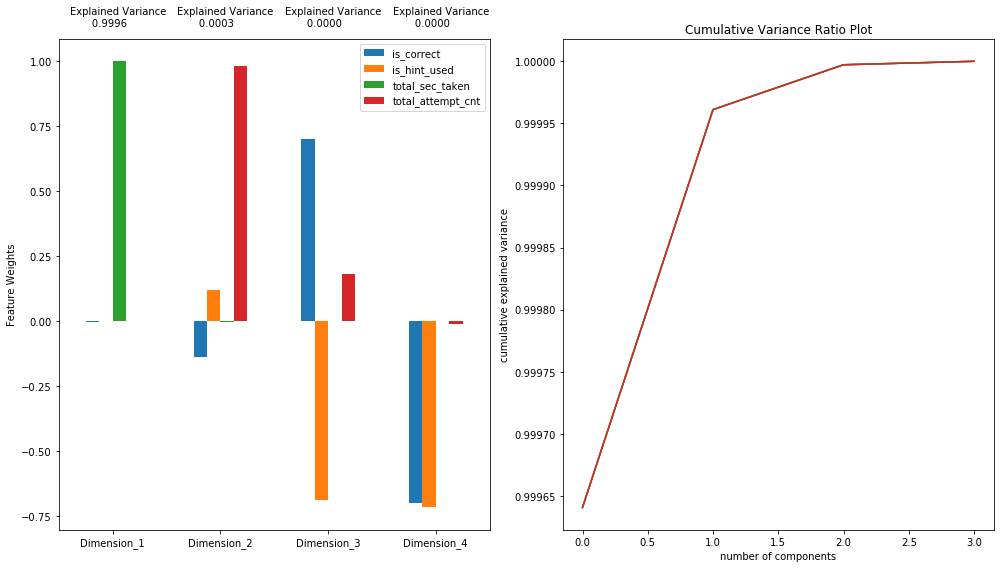

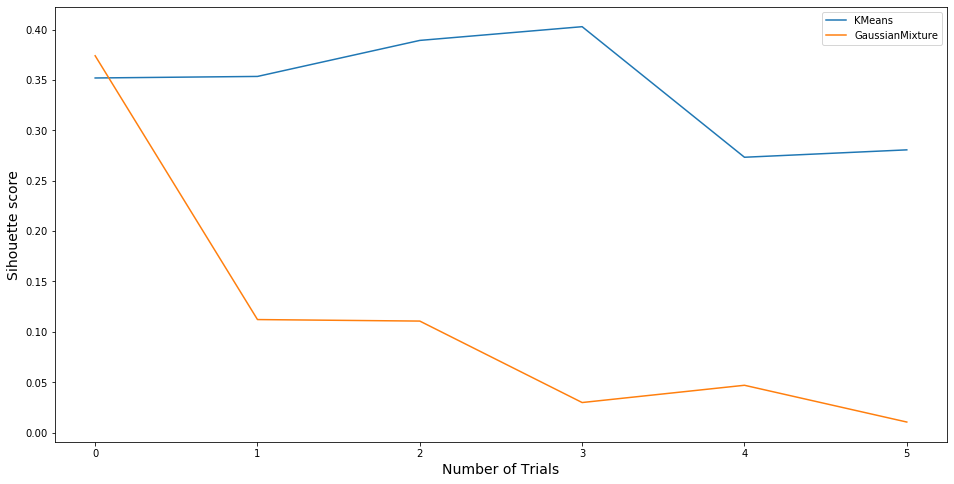

In [21]:
unique_id = user_log.iloc[:,0:1]
data = user_log.iloc[:,1:]
k_range = np.arange(2,8) # should start with 2 cluster at least
# clustering_scores = pd.DataFrame()
seed = 4103

from clustering_utils.clustering_pipeline import bt4103Clustering
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch, AffinityPropagation
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture

CC = bt4103Clustering(user_log)
CC.create_algo_input(inputs = [(KMeans, {'random_state':seed}, ('n_clusters', k_range)),
         (GaussianMixture, {'random_state':seed}, ('n_components', k_range)),]
    )
CC.clustering_preprocessing(n_components=None)
scores, unique_id = CC.run_clustering_pipeline()
CC.silhouette_analysis()

### Look at the silhouette scores from the clusters

In [24]:
CC.clustering_scores

,KMeans_hparams,KMeans,GaussianMixture_hparams,GaussianMixture
0,n_clusters_2,0.351970,n_components_2,0.374023
1,n_clusters_3,0.353502,n_components_3,0.112227
2,n_clusters_4,0.389249,n_components_4,0.110720
3,n_clusters_5,0.402867,n_components_5,0.029889
4,n_clusters_6,0.273296,n_components_6,0.047018
5,n_clusters_7,0.280637,n_components_7,0.010540


### Clusters of 5 is the best for KMeans, while 2 is the best for GMMs

In [23]:
CC.clustering_groups

,uuid,KMeans_n_clusters_5,GaussianMixture_n_components_2
0,++5bdNp/LZvGenJ8Brp4n2SfS9d4pu4qA7cF7FQW7hk=,4,0
1,++9EkR6syMGk44XpyhOj40cg9xiXwCLS/TwEy+ujrL0=,1,1
2,++E4TrlDYvGtPBg1edhkLXLEEbnfiAgAamPQ33vpW8M=,4,0
3,++G4mkLfs4WDYhc1Ga+3G+/oqSniQQvLBm7SBQ3V39Y=,1,1
4,++GobOSWqrsaxoRg1bMN+T6biIJcgBXwuOH/ddq3DiU=,4,0
...,...,...,...
72753,zztwLsjf44Uzumou84qh04wObpugkIllLCIp/mgoMu8=,0,1
72754,zzueVRV14tXIEgW4ixiqmtPNaFYz4MIifbMM/H2tmqA=,2,1
72755,zzujjvdKzb4wL8cFKdF3Of5gg2XHzIDQCZ2TfaYpSNs=,4,0
72756,zzvvUOwcSXXTXd8xoyimNcm2DjeVPLmZAI19WKfhSAM=,4,0


In [27]:
CC.clustering_scores.to_csv("user_log_clustering_scores.csv", index=False)
CC.clustering_groups.to_csv("user_log_clustering_groups.csv", index=False)